# Import Libraries

In [1]:
!nvidia-smi

Wed Apr  9 22:19:23 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8     5W /  N/A |    160MiB /  4096MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate

Setting up device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading Dataset

In [4]:
data_path = 'dataset/dataset_ver3.json'

with open(data_path, 'r', encoding='utf-8') as file:
    train_data = json.load(file)

texts = [d['text'] for d in train_data]
labels = [d['label'] for d in train_data]

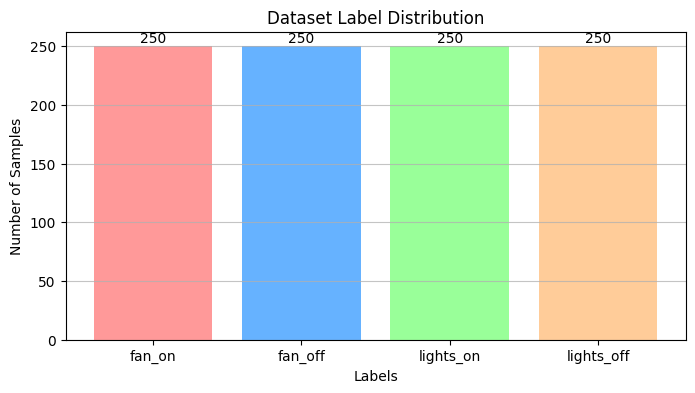

In [5]:
# Extract labels
labels = [item['label'] for item in train_data]

# Count occurrences of each label
label_counts = Counter(labels)

# Prepare data for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create bar plot
plt.figure(figsize=(8, 4))
plt.bar(label_names, label_values, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#C5B1B1'])
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Dataset Label Distribution')
plt.grid(axis='y', alpha=0.75)

# Add value labels on top of each bar
for i, v in enumerate(label_values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

Spliting dataset to train and test.

In [6]:
# Convert labels to numerical values
label_map = {"lights_on": 0, "lights_off": 1, "fan_on": 2, "fan_off": 3, "none": 4}
y = [label_map[label] for label in labels]

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(texts).toarray()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Distribution of train and test set.

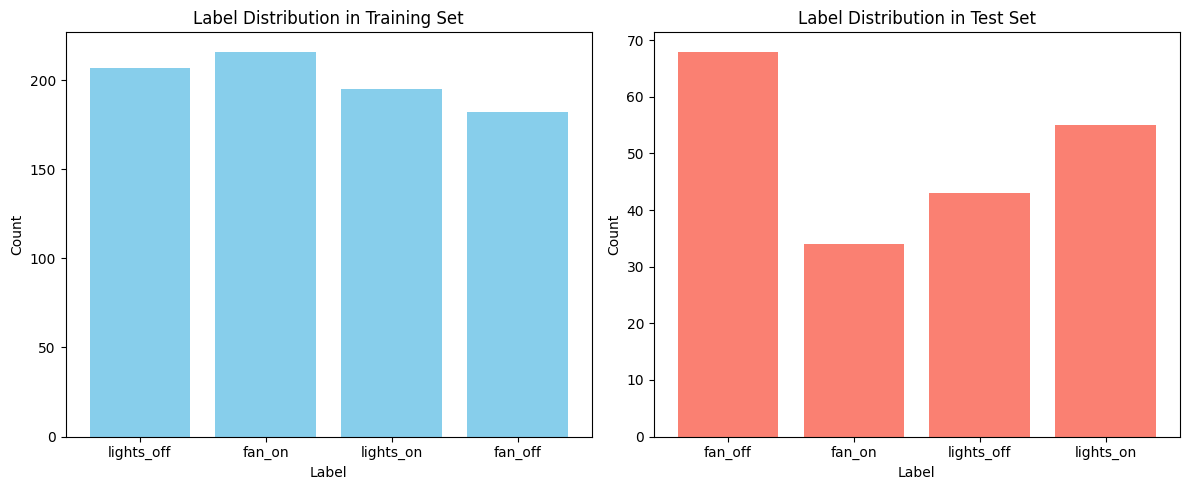

In [7]:
# Count label occurrences
train_counter = Counter(y_train)
test_counter = Counter(y_test)

# Map label indices back to names for readability
inverse_label_map = {v: k for k, v in label_map.items()}

# Convert counts to label names
train_labels = [inverse_label_map[i] for i in train_counter.keys()]
test_labels = [inverse_label_map[i] for i in test_counter.keys()]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set distribution
axes[0].bar(train_labels, train_counter.values(), color='skyblue')
axes[0].set_title('Label Distribution in Training Set')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Test set distribution
axes[1].bar(test_labels, test_counter.values(), color='salmon')
axes[1].set_title('Label Distribution in Test Set')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Dataset Module

In [8]:
# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        # If input is sparse (from TF-IDF), convert it
        if hasattr(texts, "toarray"):
            texts = texts.toarray()
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Model

In [9]:
# Neural Network Model
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_prob=0.3):
        super(TextClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Linear(hidden_size2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Training

## Hyperparameters

In [10]:
input_size = X_train.shape[1]
hidden_size1 = 512
hidden_size2 = 256
num_classes = 5
dropout = 0.3
learning_rate = 1e-3
num_epochs = 200
batch_size = 50

In [11]:
print(f'Using device: {device}')

Using device: cuda


## Loading Dataset

In [12]:
# Datasets and Loaders
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=batch_size)

## Initialize Model and Training

In [13]:
# Model, loss, optimizer
model = TextClassifier(input_size, hidden_size1, hidden_size2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Accuracy function
def evaluate_accuracy(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

In [15]:
train_losses = []

print(f"{'Epoch':^10} | {'Loss':^12} | {'Val Accuracy (%)':^17}")
print("-" * 44)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total * 100

    # Print every 10 epochs or final epoch
    if (epoch + 1) % 50 == 0 or (epoch + 1) == num_epochs:
        print(f"{epoch+1:^10} | {avg_loss:^12.4f} | {accuracy:^17.2f}")

  Epoch    |     Loss     | Val Accuracy (%) 
--------------------------------------------
    50     |    0.0008    |      100.00      
   100     |    0.0001    |      100.00      
   150     |    0.0002    |      100.00      
   200     |    0.0000    |      100.00      


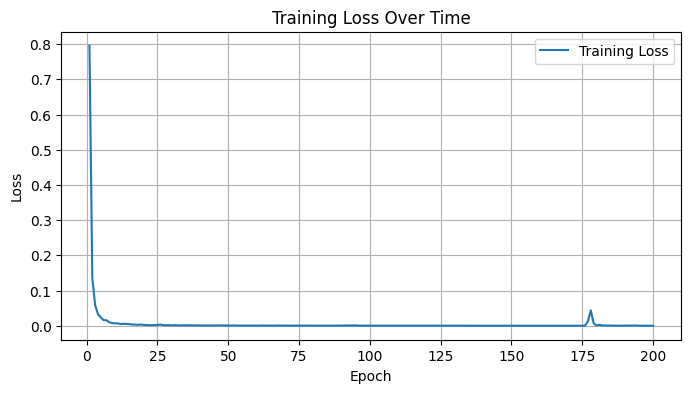

In [16]:
# Plotting the training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [17]:
# Evaluation
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Test the model
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%


# Inference

In [ ]:
# Function to predict new text
def predict_text(text, model, vectorizer):
    model.eval()
    # Transform new text using the same vectorizer
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector).to(device)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off", 4: "none"}
    return reverse_map[predicted.item()]

# Example prediction
new_text = "fan on"
prediction = predict_text(new_text, model, vectorizer)
print(f'Prediction for "{new_text}": {prediction}')

Prediction for "fan on": fan_on


## Saving Model

In [19]:
def save_model(model, vectorizer, input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, path="model/TextClassifier"):
    # Save model state dict and architecture parameters
    save_dict = {
        'state_dict': model.state_dict(),
        'input_size': input_size,
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'num_classes': num_classes,
        'dropout_prob': dropout_prob
    }

    # Save model weights
    torch.save(save_dict, f"{path}_model.pth")

    # Save vectorizer
    with open(f"{path}_vectorizer.pkl", 'wb') as f:
        pickle.dump(vectorizer, f)

    print(f"✅ Model saved to '{path}_model.pth'")
    print(f"✅ Vectorizer saved to '{path}_vectorizer.pkl'")

In [20]:
save_model(model, vectorizer, input_size, hidden_size1, hidden_size2, num_classes, dropout)

✅ Model saved to 'model/TextClassifier_model.pth'
✅ Vectorizer saved to 'model/TextClassifier_vectorizer.pkl'


# Loading Model and Inference

In [21]:
def load_model(model_class, model_path="model/TextClassifier_model.pth", vectorizer_path="model/TextClassifier_vectorizer.pkl"):
    saved_data = torch.load(model_path, map_location=device)

    input_size = saved_data['input_size']
    hidden_size1 = saved_data['hidden_size1']
    hidden_size2 = saved_data['hidden_size2']
    num_classes = saved_data['num_classes']
    dropout_prob = saved_data.get('dropout_prob', 0.3)  # Fallback if not saved

    loaded_model = model_class(input_size, hidden_size1, hidden_size2, num_classes, dropout_prob).to(device)
    loaded_model.load_state_dict(saved_data['state_dict'])
    loaded_model.eval()

    with open(vectorizer_path, 'rb') as f:
        loaded_vectorizer = pickle.load(f)

    print("✅ Model and vectorizer loaded successfully.")
    return loaded_model, loaded_vectorizer

In [22]:
# Example of how to use the loaded model
def predict_with_loaded_model(text, model, vectorizer, device):
    model.eval()
    text_vector = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vector).to(device)
    
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)
    
    reverse_map = {0: "lights_on", 1: "lights_off", 2: "fan_on", 3: "fan_off", 4: "none"}
    return reverse_map[predicted.item()]

## Inference with loaded model

In [23]:
# After training and saving, you can later load it like this:
loaded_model, loaded_vectorizer = load_model(TextClassifier)

test_samples = [
    # fan_on
    {"text": "can you turn the fan on", "label": "fan_on"},
    {"text": "fan needs to be running", "label": "fan_on"},
    {"text": "turn on the fan now", "label": "fan_on"},

    # fan_off
    {"text": "kill the fan", "label": "fan_off"},
    {"text": "turn that fan off", "label": "fan_off"},
    {"text": "yo shut off the fan", "label": "fan_off"},

    # lights_on
    {"text": "let there be light", "label": "lights_on"},
    {"text": "I can't see, lights on", "label": "lights_on"},
    {"text": "please switch the lights on", "label": "lights_on"},

    # lights_off
    {"text": "it's too bright, turn off the lights", "label": "lights_off"},
    {"text": "kill the lights", "label": "lights_off"},
    {"text": "I’m going to sleep, lights off", "label": "lights_off"},

    # none
    {"text": "what time is the meeting", "label": "none"},
    {"text": "remind me to buy milk", "label": "none"},
    {"text": "how’s the weather tomorrow", "label": "none"}
]


results = []

for sample in test_samples:
    text = sample['text']
    label = sample['label']

    prediction = predict_with_loaded_model(text, loaded_model, loaded_vectorizer, device)

    match = "✅" if prediction == label else "❌"
    results.append([text, label, prediction, match])

✅ Model and vectorizer loaded successfully.


In [24]:
# Print as a table
headers = ["Text", "True Label", "Predicted Label", "Match"]
print(tabulate(results, headers=headers, tablefmt="simple"))

Text                                  True Label    Predicted Label    Match
------------------------------------  ------------  -----------------  -------
can you turn the fan on               fan_on        fan_on             ✅
fan needs to be running               fan_on        fan_off            ❌
turn on the fan now                   fan_on        fan_on             ✅
kill the fan                          fan_off       fan_off            ✅
turn that fan off                     fan_off       fan_off            ✅
yo shut off the fan                   fan_off       fan_off            ✅
let there be light                    lights_on     lights_on          ✅
I can't see, lights on                lights_on     lights_on          ✅
please switch the lights on           lights_on     lights_on          ✅
it's too bright, turn off the lights  lights_off    lights_off         ✅
kill the lights                       lights_off    lights_off         ✅
I’m going to sleep, lights off        lig